# PFFP BlueDrop Processing Code

##### Written by: Elise Hummel, ehummel@vt.edu
##### Last updated: 1/28/2024

## Description:

This code processes raw deceleration readings (.bin files) from the BlueDrop Portable Free-Fall Penetrometer. The ouputs include a summary Excel file and various figures.

#### Required Inputs
1. BlueDrop Serial Number (1, 2, or 3)
2. File Number to process
3. Path to .bin Files
4. Soil type (if known)
5. Area calculation to be performed (mantle or projected)
6. Penetrometer tip type (conical, parabolic, or blunt)
7. Drop Type (air or water)
8. Drop Finding Method (manual or automatic)
9. Path for output table
10. Path for output figures 

#### Outputs

| Output | Sands | Clays |
| :- | -: | :-: |
| Penetration Depth (cm) | Y | Y
| Maximum Deceleration (m/s^2) | Y | Y
| Impact Velocity (m/s) | Y | Y
| Depth of Max QSBC (cm) | Y | Y
| Max Qdyn (kPa) | Y | Y
| Max QSBC (kPa) | Y | Y
| Firmness Factor (m-1) | Y | Y
| Penetration Time (ms) | Y | Y
| Relative Density (%) | Y | 
| Friction Angle (deg.) | Y | 
| Undrained shear strength | | Y | 
		

Import packages

In [357]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import math
from math import pi
from math import sqrt
import statistics
import scipy.integrate
from scipy.signal import find_peaks
from scipy.signal import argrelmin
from numpy import trapz
from scipy.integrate import cumtrapz
from scipy.integrate import dblquad

User Inputs

In [358]:
# SETUP VARIABLES - USER INPUTS
BD = 3 #Bluedrop file is from 
fileNum = '01F3' # write the bin file number you want to analyze (do not include 'bLog' or '.bin')
soiltype = "c" #s = sand, c=clay, m=mixed, u=unknown
tiptype = 'c'  # c = cone, p = parabolic, b = blunt
truncate_at_cone = "n" #"y" to end analysis at a penetration depth equal to the cone length, "n" to consider full cone length
droptype = "w" #w = water, #a = air
unit_wt = "uk" #enter an effective unit weight value in kg/m^3 or "uk" if unknown 
Nkt = 10 #default value for cone factor used in su calculations
drop_finding = "m" #"m" for manual drop picking, "a" for automatic drop picking

# paste the filepath to the folder where the BD data is stored
binFilepath = Path("C:/Users/elise/Desktop/bd_manual/sample_drops")

# paste the filepath to an excel file that the analysis results will be printed in
outputPath = Path("C:/Users/elise/Desktop/bd_manual/sample_drops/Figures/Summary_Excel.xlsx")

# paste the filepath to the folder where the output figures will be saved
plotPath = Path("C:/Users/elise/Desktop/bd_manual/sample_drops/Figures")

Define Functions for use in analysis

In [359]:
#find the penetrated area

def areafind(): #finds the embedded area based on the penetration depth, area type, and the tip
    global area_m #mantle area
    global area_p #projected area
    global trunc_index
    a_m = list() #placeholder for the penetrated area at that specific depth - mantle area
    a_p = list() #placeholder for the penetrated area at that specific depth - projected area
    d_m = dep*100 #penetration depth array, in cm - mantle area calculations
    d_p = dep*100 #penetration depth array, in cm - projected area calculations
    r_m = list() #placeholder for the radius at that specific depth - mantle area calculations
    r_p = list() #placeholder for the radius at that specific depth - mantle area calculations

    #define calculations for the cone penetrometer tip
    if tiptype == 'c': 

        #perform math for mantle area type
        for k in range(0,len(d_m)):
            if d_m[k]<length: #if full cone hasn't penetrated yet
                #r_m.append(.22+d_m[k]*((4.375-.22)/7.55)) #this is a modification for a specific tip's measurements
                r_m.append(d_m[k]*np.tan(30*pi/180)) #generic form of radius calc for a given depth
                a_m.append(pi*r_m[k]*(sqrt((r_m[k]**2)+(d_m[k]**2)))) #area calc for a given depth
            elif d_m[k]>=length: #if the full cone has penetrated
                r_m.append(4.375)
                a_m.append(pi*r_m[k]*(sqrt((r_m[k]**2)+(length**2))))
            a_m[k] = a_m[k]/10000 #converts from cm^2 to m^2
        area_m = a_m
        #print(r)
        #print(np.column_stack((d_m,r_m, area_m)))
        
        #perform math for projected area type
        for k in range(0,len(d_p)): 
            if d_p[k]<length:
                r_p.append(.22+d_p[k]*((4.375-.22)/7.55))
                # r_p.append(d_p[k]*np.tan(30*pi/180))
                a_p.append(pi*(r_p[k])**2)
            elif d_p[k]>=length:
                r_p.append(4.375)
                #if r_p[k-1]<r_p[k]:
                    #trunc_index = r_p.index(r_p[k-1])+jindex+dropstart #performs analysis only on readings beyond depth of cone height'''
                a_p.append(pi*(r_p[k])**2)
            a_p[k] = a_p[k]/10000
        area_p = a_p

        print("area_m = ", area_m, " area_p = ", area_p)

    #define calculations for the blunt penetrometer tip
    elif tiptype == 'b':

        #mantle area type calcs
        for k in range(0,len(d_m)): 
            if d_m[k]<length:
                r_m.append(4.375)
                a_m.append(pi*r_m[k]**2 + 2*pi*r_m[k]*d_m[k])
            if d_m[k]>=length:
                r_m.append(4.375)
                a_m.append(pi*r_m[k]**2 + 2*pi*r_m[k]*length)
            a_m[k]=a_m[k]/10000
        area_m = a_m

        #projected area type calcs
        for k in range(0, len(d_m)): 
            a_p.append(pi*4.375**2)
            a_p[k]=a_p[k]/10000
        area_p = a_p

    #define calculations for the parabolic penetrometer tip
    elif tiptype == "p":
        #mantle area calcs

        for k in range(0,len(d_m)):
            if d_m[k]<length:
                    r_m.append(sqrt(2.4184*d_m[k]))
                    #a_m.append(2*pi*1.03675*d_m[k]**(3/2)*((d_m[k]+0.6046)/d_m[k])**(3/2))
                    a_m.append(2*pi*((2/(3*2.4184))*(2.4184*d_m[k]+2.4184**2/4)**(3/2)-(2/(3*2.4184))*(2.4184**2/4)**3/2))

            else:
                r_m.append(4.375)

                a_m.append(2*pi*((2/(3*2.4184))*(2.4184*length+2.4184**2/4)**(3/2)-(2/(3*2.4184))*(2.4184**2/4)**3/2))
   
            a_m[k]= a_m[k]/10000
        area_m = a_m

        '''area_df = pd.DataFrame({"Radius":r_m, "Area":a_m})
        with pd.option_context('display.max_rows', None):
            display(area_df)

        print(area_m)'''

        # projected area calcs
        for k in range(0,len(d_p)):
            if d_p[k]<length:
                    r_p.append(sqrt(2.4184*d_p[k]))
                    a_p.append(pi*r_p[k]**2)
            else:
                r_p.append(4.375)
                a_p.append(pi*4.375**2)
            a_p[k]= a_p[k]/10000
        area_p = a_p
                

def qdynfun(acc): # calculates dynamic bearing capacity 
    global qdyn_m
    global qdyn_p
    global maxbcdep
    global maxqdyn_m
    global maxqdyn_p
    global qdyntable
    global maxbc_index

    buoy = 1020*0.002473
    if droptype == "w": #water drops
        Fbe = (mass-buoy)*acc #drop force

    elif droptype =="a": #air drops
        Fbe = mass*acc

    qdyn_m = (Fbe/area_m)/1000 #Dynamic bearing capacity using mantle area (kPa)
    qdyn_p = (Fbe/area_p)/1000
    qdyntable = pd.DataFrame()
    qdyntable["Mantle Qdyn"] = qdyn_m
    qdyntable["Projected Qdyn"] = qdyn_p
    qdyntable["Depth"] = dep
    if truncate_at_cone == "y":
        qdyntable = qdyntable.truncate(before=trunc_index)
    
    print(qdyntable)
    threecm_index = qdyntable[qdyntable["Depth"]>=.03].index.values.min()
    zeroth_index = qdyntable["Depth"].idxmin()

    #print("3cm index", threecm_index)
    #print("0th index", zeroth_index)
    #print(type(zeroth_index))

    qdyntable = qdyntable[threecm_index-zeroth_index:]
    print(qdyntable)

    maxqdyn_m = max(qdyntable["Mantle Qdyn"]) #gives maximum qdyn below 3cm
    maxqdyn_p = qdyntable["Projected Qdyn"].max()
    print("maxqdyn:", maxqdyn_m)
    maxbcdep = qdyntable.loc[qdyntable["Mantle Qdyn"]==maxqdyn_m, 'Depth'].item() #depth of max mantle and max projected area should be the same
    maxbc_index = qdyntable[qdyntable["Mantle Qdyn"]==maxqdyn_m].index.values

    maxqdyn_m = round(maxqdyn_m,1)
    maxqdyn_p = round(maxqdyn_p,1)
    maxbcdep = round(maxbcdep,4)
    #print("maxbcdep = ", maxbcdep) #finds the penetration depth corresponding to the maximum qdyn


    """bcmin = argrelmin(qdyn)
    peaksArray = np.array(bcmin)
    print("Peaks Array = ", peaksArray)"""

#define the QSBC function
def qsbcfun(acc): #calculates quasi-static bearing capacity
    global bctable_m #table of bearing capacity data using mantle areas
    global bctable_p #table of bearing capacity data using projected areas
    global qsbc_m #mantle qsbc
    global qsbc_p #projected qsbc
    global maxHqsbc_m #maximum qsbc averaged from the 2 highest strain rate factors and mantle area
    global maxHqsbc_p #maximum qsbc averaged from the 2 highest strain rate factors and projected area
    global maxLqsbc_m #maximum qsbc averaged from the 2 lowest strain rate factors and mantle area
    global maxLqsbc_p #maximum qsbc averaged from the 2 lowest strain rate factors and projected area
    global maxAqsbc_m #maximum qsbc from partially saturated correlation and mantle area
    global maxAqsbc_p #maximum qsbc from partially saturated correlation and mantle area
    global maxqsbc_default_m #maximum qsbc from the default strain rate factor
    global maxqsbc_default_p #maximum qsbc from the default strain rate factor
    global srfk

    if droptype == "w":
        srcv = np.log10(vel/0.02) #Velocity portion of the strain rate correction. 
        srfk = [0.1, 0.2, 0.4, 1, 1.5] #list of strain rate factors to run; must be in increasing order [.1 and 1 must be in this list!]

        #mantle area calcs
        bctable_m = pd.DataFrame()
        for i in range(0,len(srfk)):
            fsr = 1+srfk[i]*srcv
            qsbc_m = qdyn_m/fsr
            bctable_m.insert(i, "qsbc for K = "+str(srfk[i]), qsbc_m)

        #print(bctable_m)

        bctable_m_avgs = pd.DataFrame()
        bctable_m_avgs["High Average Mantle qsbc"]= (bctable_m.iloc[:,0]+bctable_m.iloc[:,1])/2 #Average of the lowest 2 strain rate factors
        bctable_m_avgs["Low Average Mantle qsbc"] = (bctable_m.iloc[:,int(len(srfk))-1]+bctable_m.iloc[:,int(len(srfk)-2)])/2 #average of the highest 2 strain rate factors
        maxHqsbc_m = bctable_m_avgs["High Average Mantle qsbc"].max()
        maxHqsbc_m = round(maxHqsbc_m, 1)
        maxLqsbc_m = bctable_m_avgs["Low Average Mantle qsbc"].max()
        maxLqsbc_m = round(maxLqsbc_m,1)
        maxAqsbc_m = "-"

        
        if soiltype == "s":
            maxqsbc_default_m = bctable_m["qsbc for K = 1"][maxbc_index].values[0]
            #maxqsbc_default_m = maxqsbc_default_m[0]


        elif soiltype == "u":
            if maxdep <= .2:
                maxqsbc_default_m = bctable_m["qsbc for K = 1"][maxbc_index].values[0]
                #maxqsbc_default_m = maxqsbc_default_m[0]
                
            else:
                maxqsbc_default_m = bctable_m["qsbc for K = 0.1"][maxbc_index].values[0]
                #maxqsbc_default_m = maxqsbc_default_m[0]
                
        elif soiltype == "c":
            maxqsbc_default_m = bctable_m["qsbc for K = 0.1"][maxbc_index].values[0]

        #projected area calcs
        bctable_p = pd.DataFrame()
        for i in range(0,len(srfk)):
            fsr = 1+srfk[i]*srcv
            qsbc_p = qdyn_p/fsr
            bctable_p.insert(i, "qsbc for K = "+str(srfk[i]), qsbc_p)

        bctable_p_avgs = pd.DataFrame()
        bctable_p_avgs["High Average Projected qsbc"]= (bctable_p.iloc[:,0]+bctable_p.iloc[:,1])/2 #Average of the lowest 2 strain rate factors
        bctable_p_avgs["Low Average Projected qsbc"] = (bctable_p.iloc[:,int(len(srfk))-1]+bctable_p.iloc[:,int(len(srfk)-2)])/2 #average of the highest 2 strain rate factors
        maxHqsbc_p = bctable_p_avgs["High Average Projected qsbc"].max()
        maxHqsbc_p = round(maxHqsbc_p, 1)
        maxLqsbc_p = bctable_p_avgs["Low Average Projected qsbc"].max()
        maxLqsbc_p = round(maxLqsbc_p,1)
        maxAqsbc_p = "-"

        if soiltype == "s":
            maxqsbc_default_p = bctable_p["qsbc for K = 1"][maxbc_index].values[0]

        elif soiltype == "u":
            if maxdep <= .2:
                maxqsbc_default_p = bctable_p["qsbc for K = 1"][maxbc_index].values[0]
                
            else:
                maxqsbc_default_p = bctable_p["qsbc for K = 0.1"][maxbc_index].values[0]
                
        elif soiltype == "c":
            maxqsbc_default_p = bctable_p["qsbc for K = 0.1"][maxbc_index].values[0]

        print("bctable_m:", bctable_m)
        

    elif droptype == "a":
        srcv = np.log10(vel/0.02) #Velocity portion of the strain rate correction. 
        srfk = 0.31*maxvel
        fsr = 1+srfk*srcv
        qsbc_m = qdyn_m/fsr
        qsbc_p = qdyn_p/fsr
        maxHqsbc_m = "-"
        maxHqsbc_p = "-"
        maxLqsbc_m = "-"
        maxLqsbc_p = "-"
        maxAqsbc_m = qsbc_m.max()
        maxAqsbc_m = round(maxAqsbc_m,1)
        maxAqsbc_p = qsbc_p.max()
        maxAqsbc_p = round(maxAqsbc_p,1)
        maxqsbc_default_m = qsbc_m[maxbc_index] 
        #maxqsbc_default_m = maxqsbc_default_m[0]
        maxqsbc_default_p = qsbc_p[maxbc_index] 
        #maxqsbc_default_p = maxqsbc_default_p[0]

    return [bctable_m, bctable_p]

# FUNCTIONS FOR USE IN ANALYSIS
def masslength(tiptype): #sets the mass and length of the pentrometer based on the tip
    global mass
    global length #lengths are in cm
    if tiptype == 'c':
        mass = 7.71 #kg
        length = 8.48-0.93 #originally 7.87, 7.57 for perfect 60 deg, 8.48 measured - .93 measured 90 deg
    elif tiptype == 'p':
        mass = 9.15
        length = 7.915
    elif tiptype == 'b':
        mass = 10.30
        length = 8.57

def dropstartend(peak): #after locating the peaks, this function chops the minute long file into a smaller segment immediately before and after the peak
    global dropstart
    global dropend
    if peak <= 1500:
        dropstart = 1
        dropend = peak + 500
    elif peak > 119500:
        dropstart = peak - 1500
        dropend = 120000
    else:
        dropstart = peak - 1500
        dropend = peak + 500

def accPick(dg, d): #this function picks the smallest accelerometer that's not maxed out to perform the integration on
    maxAcc = dg["250g (g)"].max()

    global acc
    global accName
    global accNameg
    global accg
    if maxAcc < 5: 
        if dg["2g (g)"].max() < 1.8:   # does an extra check for the 2g because of noise
            acc = dfCal["2g (m/s^2)"]
            accg = dfCalg["2g (g)"]
            accName = "2g (m/s^2)"
            accNameg = "2g (g)"
        else:
            acc = dfCal["18g (m/s^2)"]
            accg = dfCalg["18g (g)"]
            accName = "18g (m/s^2)"
            accNameg = "18g (g)"
    elif maxAcc < 18:
        acc = dfCal["18g (m/s^2)"]
        accg = dfCalg["18g (g)"]
        accName = "18g (m/s^2)"
        accNameg = "18g (g)"
    elif maxAcc < 50: 
        acc = dfCal["50g (m/s^2)"]
        accg = dfCalg["50g (g)"]
        accName = "50g (m/s^2)"
        accNameg = "50g (g)"
    else:
        acc = dfCal["250g (m/s^2)"]
        accg = dfCalg["50g (g)"]
        accName = "250g (m/s^2)"
        accNameg = "250g (g)"

def findchangepts(): #This function picks the moment that the BD impacts the ground (not in use currently)
    global drop
    jlist = list()
    global jindex
    print("finding start of drop...")
    for i in range(4,len(accg)-4):
        p1 = 1
        #print(p1)
        p2 = i
        #print(p2)
        p3 = len(accg)
        #print(p3)
        sample1 = list(accg[p1:p2-1])
        #print(sample1)
        sample2 = list(accg[p2:p3])
        #print(sample2)
        stat1 = math.log(statistics.variance(sample1))
        stat2 = math.log(statistics.variance(sample2))
        #print(stat1)

        j1 = (i-1)*stat1
        j2 = ((len(accg)-1)-i+1)*stat2
        j = j1+j2
        #print(j)
        jlist.append(j)

    drop = min(jlist)
    #print("drop is")
    #print(drop)
    jlist = np.array(jlist)
    #print(jlist)
    #print(jlist.size)
    jlist = np.insert(jlist, 0, (0,0,0,0)) #reshape to match up with dataframe d
    jlist = np.append(jlist, (0,0,0,0)) #reshape to match up with dataframe d
    #print(jlist.size) #should be 2000
    jindex = np.where(jlist==drop) #finds the index of the drop start
    jindex = int(jindex[0]) #converts the index into a number from a tuple
    print("Jlist: ", jlist)

def finddropend(n): #finds the location after the peak where the deceleration is 1 
    global penend
    below0list = list()
    #for i in range(dropstart+jindex, dropend, 1):
    for i in range(peak, dropend, 1):
        if accg[i] < 1: #the offset is applied later in the code
            penend = i 
            below0list = np.append(below0list, penend)
    penend=int(min(below0list))

def integration(d, accint): #integrates the deceleration data to solve for velocity and penetration depth
    global vel
    global maxvel
    global dep
    global maxdep
    #accint = acc[penstart:penend]
    #print(len(d))
    #print(len(accint))
    vel = scipy.integrate.cumtrapz(accint, x=d["Time (s)"])  # solves for velocity
    vel = np.array(vel)
    vel = np.insert(vel, 0, 0) #not sure what to insert here, but it makes it the right size
    vel = np.flip(vel)
    maxvel = vel.max()
    maxvel = round(maxvel,1)
    dep = scipy.integrate.cumtrapz(vel, x=d["Time (s)"])  # solves for penetration depth
    dep = np.insert(dep, 0, 0)  # not sure what to insert here, but it makes it the right size
    maxdep = dep.max()
    maxdep = round(maxdep,4)
    d.insert(9, "Velocity (m/s)", vel)
    d.insert(10, "Penetration Depth (m)", dep)

def peakpick():
    global penstart
    matplotlib.use('TkAgg')
    fig, (ax1) = plt.subplots(1)
    plt.plot(dfCalg['Count'], dfCalg[accNameg], label=accNameg)
    plt.plot(dfCalg['Count'], dfCalg['2g (g)'], label='2g')

    ax1.set_xlim(left=dropstart, right=dropend)
    ax1.legend()
    ax1.set(ylabel="Deceleration (g)")
    ax1.set(xlabel="Time")
    ax1.set_title('Double-click start of drop #' + str(n))
    startendpt = plt.ginput(2, 0)
    pentimes = []
    for t in startendpt:
        for x in t:
            pentimes.append(x)

    penstart = int(pentimes[0])
    print("start of penetration: ", penstart)

def endpick():
    global penend
    matplotlib.use('TkAgg')
    fig, (ax1) = plt.subplots(1)
    plt.plot(dfCalg['Count'], dfCalg[accNameg], label=accNameg)
    plt.plot(dfCalg['Count'], dfCalg['2g (g)'], label='2g')
    plt.hlines(1, 0, 120000, linestyles="--", color = "k")

    ax1.set_xlim(left=dropstart, right=dropend)
    ax1.legend()
    ax1.set(ylabel="Deceleration (g)")
    ax1.set(xlabel="Time")
    ax1.set_title('Double-click end of drop #' + str(n))
    startendpt = plt.ginput(2, 0)
    pentimes = []
    for t in startendpt:
        for x in t:
            pentimes.append(x)

    penend = int(pentimes[0])

def CheckingFunction(): # (to be used with auto peak finding) This function is added to check the values of the start and end of the drop if the autofinding function doesn't work

    global jindex
    global num1
    
    xvalues=np.linspace(0,len(dg)-1,len(dg))
    plt.figure(num=1)
    temp_dg=dg['250g (g)']
    plt.plot(xvalues,temp_dg)
    plt.grid(visible=True,which='both')
    plt.show()
    print ('The start of the drop is', jindex)
    print ('The end of the drop is', num1)
    print('Are the start and end of the drop correct?(y/n)')
    drop_input=input()
    if drop_input=='n':   
        peakpick()
        jindex = penstart
        num1 = penend

def dr(accg): #Albatal 2019 method for calculating relative density (Duck, NC specific!)
    maxacc = accg.max() #maximum deceleration, in g
    print("Max deceleration = ", maxacc)
    Dr = -2.18*10**-4*maxacc**3+1.29*10**-2*maxacc**2+1.61*maxacc-13.09 #Albatal 2019
    Dr = round(Dr, 1)
    return Dr
    #print("Relative density is ", dr)

def ignore_drop():
    global keep_drop
    print('Keep Drop? (y/n)')
    keep_drop=input()

def duncan_correlation(Dr): #duncan correlation for caluclating friction angle
    global sign
    #coefficients A, B, C, and D used in the Duncan Correlation. Duncan[34,10,3,2], Albatal[34,10,2,5]
    A = 34
    B = 10
    C = 3
    D = 2
    pa = 101.325 #kPa
    print("max penetration depth = ", maxdep)
    if unit_wt == "uk":
        sign = 1120*maxdep #1120 = 70pcf in kg/m^3
    else:
        sign = unit_wt*maxdep 


    phi = A + B*Dr/100-(C+D*Dr/100)*math.log(sign/pa)
    phi = round(phi, 1)
    print("phi =", phi)
    return phi

def firmnessfactor(acc, drop):
    global maxacc
    global ff
    maxacc = acc.max()[0]
    g = 9.80665
    tp = len(drop)/2000

    ff = maxacc/(g*tp*maxvel)
    ff = round(ff,1)
    #ff = ff[0]
    print("Firmness factor = ", ff)

def bctruncate(dropg, drop, acc, qdyn):
    dropg = pd.DataFrame(dropg)
    drop = pd.DataFrame(drop)
    qdyn = pd.DataFrame(qdyn)
    acc = pd.DataFrame(acc)
    dropg = dropg.truncate(before=trunc_index)
    drop = drop.truncate(before=trunc_index)
    acc = acc.truncate(before=trunc_index)
    qdyn = qdyn.truncate(before=trunc_index)

def manual_peak_pick():
    x = np.array(g250g)
    matplotlib.use('TkAgg')

    plt.plot(x)
    plt.title("Select Drops (Enter to Exit)")
    plt.xlabel("Count")
    plt.ylabel("Deceleration (g)")
    #plt.legend("Deceleration (g)", "Pore Pressure (kPa)")
    plt.grid(True)
    #plt.show()
    global peaksArray
    global nDrops
    
    peak_approx_list = []

    peak_approx = plt.ginput(n=-1, show_clicks=True)
    for t in peak_approx:
        for x in t:
            peak_approx_list.append(x)
    #user_input = input("Enter a value (press Enter to stop): ")
    plt.close()

    nDrops = int(len(peak_approx_list)/2)
    #print(num_drops, "drops in file")

    approx_peak_index_list = peak_approx_list[::2]
    for a in range(0,len(approx_peak_index_list)):
        approx_peak_index_list[a] = int(approx_peak_index_list[a])
    #print("Coordinates of Approximate peaks (index, acceleration):", peak_approx_list)
    #print("Approx Peak Indexes:", approx_peak_index_list) 

    plot_start_list = []
    plot_end_list = [] 
    index_list = []
    for a in range(0, nDrops):
        peak = approx_peak_index_list[a]
        if peak <= 3000:
            plotstart = 1
            plotend = peak + 500
            
        elif peak > 119500:
            plotstart = peak - 3000
            plotend = 120000
        else:
            plotstart = peak - 3000
            plotend = peak + 500
        plot_start_list.append(plotstart)
        plot_end_list.append(plotend)
        index_list.append(a+1)
    plot_ranges = {'Start':plot_start_list, "End":plot_end_list}
    plot_range_df = pd.DataFrame(data=plot_ranges, index = index_list)
    #print(plot_range_df)

    #finds the actual maximum deceleration (not just the approximated one)
    #print(plot_range_df.at[1,'Start'])
    max_dec_list = []
    for a in range(1, nDrops+1):
        max_dec = max(g250g[plot_range_df.at[a,'Start']:plot_range_df.at[a,'End']])
        max_dec_list.append(max_dec)
        #print(max_dec) #these should match the maximum values shown in cell []
    #print(max_dec_list)

    #makes a dataframe of only deceleration values
    index_df = pd.DataFrame(data={'Acc':g250g}, index = range(0,len(g250g)))
    #print(index_df)

    max_index_list = []
    #finds the index of the maximum deceleration values
    for a in range(1, nDrops+1):
        drop_range = index_df[plot_range_df.at[a,'Start']:plot_range_df.at[a,'End']]
        #print(drop_range)
        #print(drop_range.idxmax().values)
        max_index = drop_range.idxmax().values
        max_index = int(max_index)
        max_index_list.append(max_index)
        #print(max_index)
    #print(max_index_list)
    peaksArray = np.array(max_index_list)

#Exporting Functions
def exporttoexcel():
    with pd.ExcelWriter(outputPath, mode="a", if_sheet_exists='replace') as writer:
        output_table.to_excel(writer, sheet_name = fileNum, index=False)



Plot Definitions

In [360]:
#QSBC plots

def dep_qsbc_comboplot(dropg, drop, accNameg, qdyn, qsbc, bctable):
    #matplotlib.use('TkAgg')
    %matplotlib inline
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(7, 7)
    ax1.plot(dropg[accNameg], drop["Penetration Depth (m)"]*100, color = "k", linestyle = "solid") #marker = 11
    ax1.plot(drop["Velocity (m/s)"], drop["Penetration Depth (m)"]*100, color = "k", linestyle = "dashed")
    ax1.plot(drop["X55g (m/s^2)"], drop["Penetration Depth (m)"]*100, color = "b", linestyle = "dashed")
    ax1.plot(drop["Y55g (m/s^2)"], drop["Penetration Depth (m)"]*100, color = "r", linestyle = "dashed")
    ax1.set(xlabel="Deceleration (g) and Velocity (m/s)", ylabel="Penetration Depth (cm)")
    ax1.invert_yaxis()
    ax1.legend(["Deceleration (g)", "Velocity (m/s)", "X tilt (g)", "Y tilt (g)"], loc = "upper right")
    ax1.set_title("BD file "+fileNum)
    ax1.grid()

    if droptype == "a": #for partial saturation, only one qsbc curve
        ax2.plot(qdyn, drop["Penetration Depth (m)"]*100, label="Qdyn") #color = "k", marker = 11 #Plots Qdyn
        ax2.plot(qsbc, drop["Penetration Depth (m)"]*100, label="QSBC") #plots QSBC
        ax2.set(xlabel="Bearing Capacity (kPa)")
        ax2.set_xlim(0,800)
        ax2.invert_yaxis()
        ax2.legend(["Qdyn", "QSBC"], loc = "upper right")
        ax2.set_title("Drop #"+str(n))
        ax2.grid()

    else: #for saturated drops, use a range of strain-rate factors
        n_srf = len(bctable.columns) #number of strain rate factors checked 
        ax2.plot(qdyn, drop["Penetration Depth (m)"]*100, label="Qdyn") #color = "k", marker = 11 #Plots Qdyn
        ax2.plot(bctable.iloc[:,0], drop["Penetration Depth (m)"]*100, label=str(bctable.columns[0])) #plots QSBC with smallest srf
        ax2.plot(bctable.iloc[:,n_srf-1], drop["Penetration Depth (m)"]*100, label=str(bctable.columns[n_srf-1])) #plots QSBC with largest srf
        for i in range(1,n_srf-1): #plots qsbc for all other srfs
            ax2.plot(bctable.iloc[:,i], drop["Penetration Depth (m)"]*100, label=str(bctable.columns[i]), color = '.6')
        ax2.set(xlabel="Bearing Capacity (kPa)")
        ax2.set_xlim(0,)
        ax2.invert_yaxis()
        ax2.legend(["Qdyn", str(bctable.columns[0]), str(bctable.columns[n_srf-1])], loc = "upper right")
        ax2.set_title("Drop #"+str(n))
        ax2.grid()
    
    fig.subplots_adjust(bottom=.1, left = .1)

def final_dep_qsbc_comboplot(dropg, drop, accNameg, qdyn, qsbc, bctable):
    %matplotlib inline
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(7, 7)
    ax1.plot(dropg[accNameg], drop["Penetration Depth (m)"]*100, color = "k", linestyle = "solid") #marker = 11
    ax1.plot(drop["Velocity (m/s)"], drop["Penetration Depth (m)"]*100, color = "k", linestyle = "dashed")
    #ax1.plot(drop["X55g (m/s^2)"], drop["Penetration Depth (m)"]*100, color = "b", linestyle = "dashed")
    #ax1.plot(drop["Y55g (m/s^2)"], drop["Penetration Depth (m)"]*100, color = "r", linestyle = "dashed")
    ax1.set(xlabel="Deceleration (g) and Velocity (m/s)", ylabel="Penetration Depth (cm)")
    ax1.invert_yaxis()
    ax1.legend(["Deceleration (g)", "Velocity (m/s)"])
    ax1.set_title("BD file "+fileNum)
    ax1.grid()

    if droptype == "a": #for partial saturation, only one qsbc curve
        y = drop["Penetration Depth (m)"]*100
        ax2.plot(qdyn[10:], y[10:], label="Qdyn") #color = "k", marker = 11 #Plots Qdyn, chops off first 10 readings
        ax2.plot(qsbc[10:-20], y[10:-20], label="QSBC") #plots QSBC; chops off last 20 points which go off towards infinity (can adjust as needed)
        ax2.set(xlabel="Bearing Capacity (kPa)",)
        ax2.set_xlim(0,)
        ax2.invert_yaxis()
        ax2.legend(["Qdyn", "QSBC"], loc = "upper right")
        ax2.set_title("Drop #"+str(n))
        ax2.grid()

    else: #for saturated drops, use a range of strain-rate factors
        n_srf = len(bctable.columns) #number of strain rate factors checked 
        y = drop["Penetration Depth (m)"]*100 #[changed this]
        upper_bound = 10
        lower_bound = -60
        ax2.plot(qdyn[upper_bound:lower_bound], y[upper_bound:lower_bound], label="Qdyn") #color = "k", marker = 11 #Plots Qdyn
        ax2.plot(bctable.iloc[upper_bound:lower_bound,0], y[upper_bound:lower_bound], label=str(bctable.columns[0])) #plots QSBC with smallest srf
        ax2.plot(bctable.iloc[upper_bound:lower_bound,len(bctable.columns)-1], y[upper_bound:lower_bound], label=str(bctable.columns[len(bctable.columns)-1])) #plots QSBC with largest srf
        for i in range(1,n_srf-1): #plots qsbc for all other srfs
            ax2.plot(bctable.iloc[upper_bound:lower_bound,i], y[upper_bound:lower_bound], label=str(bctable.columns[i]), color = '.6')
            #bctablet.iloc[:,i].pop()
        ax2.set(xlabel="Bearing Capacity (kPa)")
        ax2.set_xlim(0,) #//**// can change as needed
        ax2.invert_yaxis()
        ax2.legend(["Qdyn", str(bctable.columns[0]), str(bctable.columns[n_srf-1])], loc = "upper right")
        ax2.set_title("Drop #"+str(n))
        ax2.grid()

    fig.subplots_adjust(bottom=.1, left = .1)
    #plotName = fileNum+" "+str(n)+" BC"
    #plt.savefig(plotPath / plotName)
    #plt.show()

def duck_dep_qsbc_comboplot(dropg, drop, dropt, accNameg, qdynt):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(7, 7)
    ax1.plot(dropg[accNameg], drop["Penetration Depth (m)"]*100, color = "k", linestyle = "solid") #marker = 11
    ax1.plot(drop["Velocity (m/s)"], drop["Penetration Depth (m)"]*100, color = "k", linestyle = "dashed")
    #ax1.plot(drop["X55g (m/s^2)"], drop["Penetration Depth (m)"]*100, color = "b", linestyle = "dashed")
    #ax1.plot(drop["Y55g (m/s^2)"], drop["Penetration Depth (m)"]*100, color = "r", linestyle = "dashed")
    ax1.set(xlabel="Deceleration (g) and Velocity (m/s)", ylabel="Penetration Depth (cm)")
    ax1.invert_yaxis()
    ax1.legend(["Deceleration (g)", "Velocity (m/s)"])
    ax1.set_title("BD file "+fileNum)
    ax1.grid()

    if droptype == "a": #for partial saturation, only one qsbc curve
        y = dropt["Penetration Depth (m)"]*100
        ax2.plot(qdynt[10:], y[10:], label="Qdyn") #color = "k", marker = 11 #Plots Qdyn, chops off first 40 readings
        ax2.plot(qsbc[10:-20], y[10:-20], label="QSBC") #plots QSBC; chops off last 10 points which go off towards infinity (can adjust as needed)
        ax2.set(xlabel="Bearing Capacity (kPa)",)
        ax2.set_xlim(0,qdyn.max())
        ax2.invert_yaxis()
        ax2.legend(["Qdyn", "QSBC"], loc = "upper right")
        ax2.set_title("Drop #"+str(n))
        ax2.grid()

    else: #for saturated drops, use a range of strain-rate factors
        y = list(dropt["Penetration Depth (m)"]*100)
        ax2.plot(qdynt[10:-20], y[10:-20], label="Qdyn") #color = "k", marker = 11 #Plots Qdyn
        ax2.plot(bctablet.iloc[10:-20,0], y[10:-20], label=str(bctablet.columns[0])) #plots QSBC with smallest srf
        ax2.plot(bctablet.iloc[10:-20,len(bctable.columns)-1], y[10:-20], label=str(bctable.columns[len(bctable.columns)-1])) #plots QSBC with largest srf
        for i in range(1,len(bctablet.columns)-1): #plots qsbc for all other srfs
            ax2.plot(bctablet.iloc[10:-20,i], y[10:-20], label=str(bctablet.columns[i]), color = '.6')
            #bctablet.iloc[:,i].pop()
        ax2.set(xlabel="Bearing Capacity (kPa)")
        ax2.set_xlim(0,)
        ax2.invert_yaxis()
        ax2.legend(["Qdyn", str(bctablet.columns[0]), str(bctablet.columns[len(bctablet.columns)-1])], loc = "upper right")
        ax2.set_title("Drop #"+str(n))
        ax2.grid()

    fig.subplots_adjust(bottom=.1, left = .1)
    plotName = fileNum+" "+str(n)+" BC"
    plt.savefig(plotPath / plotName)
    plt.show()

#Plots for exporting
def overviewplot(): #Plot showing all accellerometers and pore pressure readings
    %matplotlib inline
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    fig.set_size_inches(14, 7)
    #plt.tight_layout()
    ax1.plot(time, g250g, label="250g")
    ax1.plot(time, g50g, label="50g")
    ax1.plot(time, g18g, label="18g")
    ax1.plot(time, g2g, label="2g")
    ax1.legend(loc = "upper right")
    ax1.set(ylabel="Deceleration (g)")
    ax1.set_title("BD file "+fileNum)
    ax1.grid()

    ax2.plot(time, ppm, label="Pore Pressure")
    ax2.set(ylabel="Pore Pressure (kPa)")
    ax2.grid()

    ax3.plot(time, gX55g, label="X 55g")
    ax3.plot(time, gY55g, label="Y 55g")
    ax3.legend(loc = "upper right")
    ax3.set(ylabel="Deceleration (g)")
    ax3.set(xlabel="Time (s)")
    ax3.grid()

    fig.subplots_adjust(bottom=.1, left = .1)
    plotName = fileNum+" Overview.png"
    plt.savefig(plotPath / plotName)
    plt.show()

def integplot(drop, accName): #Deceleration,Velocity,and penetration depth vs time plots
    %matplotlib inline
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    fig.set_size_inches(7, 7)
    #resize to 7,7, 7,14
    #plt.tight_layout()
    timereset = drop["Time (s)"]- drop["Time (s)"].iloc[0]
    ax1.plot(timereset, drop[accName], color = "k" ) #,marker = 11
    ax1.set(ylabel="Deceleration (m/s^2)")
    ax1.set_title("BD file "+fileNum+ " Drop #"+str(n))
    ax1.grid()

    ax2.plot(timereset, drop['Velocity (m/s)'] , color = "k" )
    ax2.set(ylabel="Velocity (m/s)")
    ax2.grid()

    ax3.plot(timereset, drop["Penetration Depth (m)"] , color = "k")
    ax3.set(ylabel="Penetration Depth (m)", xlabel="Time(s)")
    ax3.grid()

    fig.subplots_adjust(bottom=.1, left = .1)
    plotName = fileNum+" "+str(n)+" Integ"
    plt.savefig(plotPath / plotName)
    plt.show()

#plots for troubleshooting 
def depthplot(dropg, drop, accNameg): #Velocity and develeration vs. penetration depth 
    %matplotlib inline
    fig, (ax1) = plt.subplots(1)
    ax1.plot(dropg[accNameg], drop["Penetration Depth (m)"]*100, color = "k", linestyle = "solid") #marker = 11
    ax1.plot(drop["Velocity (m/s)"], drop["Penetration Depth (m)"]*100, color = "k", linestyle = "dashed")
    ax1.set(xlabel="Deceleration (g) and Velocity (m/s)", ylabel="Penetration Depth (cm)")
    ax1.invert_yaxis()
    ax1.legend(["Deceleration (g)", "Velocity (m/s)"])
    ax1.set_title("BD file "+fileNum)
    plt.show()

def peakplot(): # Plot showing peak deceleration
    %matplotlib inline
    fig, (ax1) = plt.subplots(1)
    x=np.array(g250g)
    plt.plot(x)
    plt.plot(peaksArray, x[peaksArray], "x")
    ax1.set(xlabel="Count", ylabel="Deceleration (g)")
    ax1.set_title("Drop Locations")
    plt.show()

def qdynplot(drop, qdyn): #Plot showing dynamic bearing capacity vs depth
    %matplotlib inline
    #print(len(drop))
    #print(len(qdyn))
    #print((bctable.iloc[:,0]))
    #print(len(bctable.iloc[:,len(bctable.columns)-1]))
    fig, (ax1) = plt.subplots(1)

    if droptype == "a": #for partial saturation, only one qsbc curve
        ax1.plot(qdyn, drop["Penetration Depth (m)"]*100, label="Qdyn") #color = "k", marker = 11 #Plots Qdyn
        ax1.plot(qsbc, drop["Penetration Depth (m)"]*100, label="QSBC") #plots QSBC
        ax1.set(xlabel="Bearing Capacity (kPa)")
        ax1.set_xlim(0,)
        ax1.invert_yaxis()
        ax1.legend(["Qdyn", "QSBC"])
        ax1.set_title("Bearing Capacity- "+fileNum+ " "+str(n))
        ax1.grid()

    else:
        ax1.plot(qdyn, drop["Penetration Depth (m)"]*100, label="Qdyn") #color = "k", marker = 11 #Plots Qdyn
        ax1.plot(bctable.iloc[:,0], drop["Penetration Depth (m)"]*100, label=str(bctable.columns[0])) #plots QSBC with smallest srf
        ax1.plot(bctable.iloc[:,len(bctable.columns)-1], drop["Penetration Depth (m)"]*100, label=str(bctable.columns[len(bctable.columns)-1])) #plots QSBC with largest srf
        for i in range(1,len(bctable.columns)-1): #plots qsbc for all other srfs
            ax1.plot(bctable.iloc[:,i], drop["Penetration Depth (m)"]*100, label=str(bctable.columns[i]), color = "k")
        ax1.set(xlabel="Bearing Capacity (kPa)", ylabel="Penetration Depth (cm)")
        ax1.set_xlim(0,)
        ax1.invert_yaxis()
        ax1.legend(["Qdyn", str(bctable.columns[0]), str(bctable.columns[len(bctable.columns)-1])])
        ax1.set_title("Bearing Capacity- "+fileNum+ " "+str(n))
    
    plt.show()

def tiltplot():
    %matplotlib inline
    fig, (ax1) = plt.subplots(1)
    plt.plot(time, gX55g, label="2g")
    plt.plot(time, gY55g, label="2g")
    ax1.legend()
    ax1.set(ylabel="Deceleration (g)")
    ax1.set(xlabel="Time (s)")
    ax1.set_title("BD file "+fileNum)



In [361]:
def su_plot(drop, su_type):
    %matplotlib inline
    upper_bound = 10
    lower_bound = -60
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(7, 7)
    ax1.plot(su_type[upper_bound:lower_bound], drop["Penetration Depth (m)"][upper_bound:lower_bound]*100, color = "k", linestyle = "solid") #marker = 11
    ax1.set(xlabel="Undrained Strength (kPa)", ylabel="Penetration Depth (cm)")
    ax1.invert_yaxis()
    ax1.grid()

In [362]:
def su_plot_with_range(dropg, drop, accNameg, qsbc, bctable): 

    %matplotlib inline
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(7, 7)
    ax1.plot(dropg[accNameg], drop["Penetration Depth (m)"]*100, color = "k", linestyle = "solid") #marker = 11
    ax1.plot(drop["Velocity (m/s)"], drop["Penetration Depth (m)"]*100, color = "k", linestyle = "dashed")
    #ax1.plot(drop["X55g (m/s^2)"], drop["Penetration Depth (m)"]*100, color = "b", linestyle = "dashed")
    #ax1.plot(drop["Y55g (m/s^2)"], drop["Penetration Depth (m)"]*100, color = "r", linestyle = "dashed")
    ax1.set(xlabel="Deceleration (g) and Velocity (m/s)", ylabel="Penetration Depth (cm)")
    ax1.invert_yaxis()
    ax1.legend(["Deceleration (g)", "Velocity (m/s)"])
    ax1.set_title("BD file "+fileNum)
    ax1.grid()

    if droptype == "a": #for partial saturation, only one qsbc curve
        y = drop["Penetration Depth (m)"]*100
        ax2.plot(qsbc[10:-20]/Nkt, y[10:-20]) #plots QSBC; chops off last 20 points which go off towards infinity (can adjust as needed)
        ax2.set(xlabel="Undrained Strength (kPa)")
        ax2.set_xlim(0,)
        ax2.invert_yaxis()
        ax2.legend(["su"], loc = "upper right")
        ax2.set_title("Drop #"+str(n))
        ax2.grid()

    else: #for saturated drops, use a range of strain-rate factors
        n_srf = len(bctable.columns) #number of strain rate factors checked 
        y = drop["Penetration Depth (m)"]*100
        upper_bound = 10
        lower_bound = -60
        ax2.plot(bctable.iloc[upper_bound:lower_bound,0]/Nkt, y[upper_bound:lower_bound]) #plots QSBC with smallest srf
        ax2.plot(bctable.iloc[upper_bound:lower_bound,len(bctable.columns)-1]/Nkt, y[upper_bound:lower_bound]) #plots QSBC with largest srf
        for i in range(1,n_srf-1): #plots qsbc for all other srfs
            ax2.plot(bctable.iloc[upper_bound:lower_bound,i]/Nkt, y[upper_bound:lower_bound], color = '.6')
            #bctablet.iloc[:,i].pop()
        ax2.set(xlabel="Undrained Strength (kPa)")
        ax2.set_xlim(0,) #//**// can change as needed
        ax2.invert_yaxis()
        ax2.legend(["K = " + str(srfk[0]), "K = " + str(srfk[-1])], loc = "upper right")
        ax2.set_title("Drop #"+str(n))
        ax2.grid()

    fig.subplots_adjust(bottom=.1, left = .1)
    #plotName = fileNum+" "+str(n)+" BC"
    #plt.savefig(plotPath / plotName)
    #plt.show()

Bring in penetrometer data

In [363]:
#Set the penetrometer mass and length
masslength(tiptype)

# READ BD DATA IN
data_array = []  # creates an empty array for us to fill with bd data
fileName = 'bLog'+fileNum+".bin"
# print(fileName)
newPath = binFilepath / fileName
#print(newPath)
file = open(newPath, 'rb')  # read file
element = file.read(3)  # create a byte list with each element having 3 bytes

while element:
    # Convert to signed integer before adding to data array
    iVAl = int.from_bytes(element, byteorder='big', signed=True)
    data_array.append(iVAl)  # adds the reshaped data from the bd file to the data frame
    element = file.read(3)

np_array = np.array(data_array)  # create numpy array from the list
np_array = np.reshape(np_array, (-1, 10))  # convert the 1d array to 2d array with 10 cols

#print(np_array.shape)
# print(np_array)

df = pd.DataFrame(np_array) # Creates a Dataframe in pandas from the bd data
df.columns = ['Count', 'no clue', 'g2g', 'g18g', 'g50g', 'ppm', 'g200g', 'gX55g', 'gY55g', 'g250g'] # names columns
# print(dfCal)

Apply Calibration Factors

In [364]:
# APPLY CALIBRATION FACTORS
if BD == 3:  # calibration factors from Sequim 2021
    g2g = (df['g2g']-34426.5)/1615925.8 # accelerometers are in g
    g18g = (df['g18g']+12322.1)/163530.7
    g50g = (df['g50g']-237384.9)/63651 - 0.1120
    ppm = ((df['ppm']+62496.7)/20705) * 6.89475729 -38# converts to kPa
    g200g = (df['g200g'] -262332.4)/38888.7 
    gX55g = (df['gX55g']-59093.7)/66674.3
    gY55g = (df['gY55g']-140224.6)/66674.3
    g250g = (df['g250g']-40536.1)/13631.6

if BD == 2: # calibration factors from March 2023
    g2g = (df['g2g']+36597.6)/1637627.3 # accelerometers are in g
    g18g = (df['g18g']-26185.3)/160297.2 
    g50g = (df['g50g']-212256.9)/63968.7 
    ppm = ((df['ppm']+55518.9)/18981.7) * 6.89475729 # converts to kPa
    g200g = (df['g200g']-175499.4)/30583.8
    gX55g = (df['gX55g']-53629.9)/68590.9
    gY55g = (df['gY55g']-43694.3)/68280.3
    g250g = (df['g250g']-39619.9)/13545.8

if BD == 1: # calibration factors from March 2023
    g2g = (df['g2g']-43727.6)/1625064  # accelerometers are in g
    g18g = (df['g18g']-45085.6)/160925.7 
    g50g = (df['g50g']-173493.4)/63944.6 
    ppm = ((df['ppm']+31776.1)/20679.7) * 6.89475729 # this is kPa
    g200g = (df['g200g'] -731734.3)/32192.4  
    gX55g = (df['gX55g'] -68837.9)/52137.3
    gY55g = (df['gY55g']-68015.9)/28074.9
    g250g = (df['g250g']+10580)/13688.7 

Create Calibrated Dataframes for Penetrometer Data

In [365]:
time = (df['Count']-df['Count'].iloc[0]+1)/2000 # gives time in s
count = df["Count"]-df['Count'].iloc[0]

# make a new dataframe of the calibrated values in units of g
dfCalg = pd.DataFrame([count, time, g2g, g18g, g50g, g200g, g250g, gX55g, gY55g, ppm])
dfCalg = dfCalg.T
dfCalg.columns = ['Count', 'Time (s)', '2g (g)', '18g (g)', '50g (g)', '200g (g)', '250g (g)', 'X55g (g)', 'Y55g (g)', 'Pore Pressure (kPa)']  # names columns
#print(dfCalg)

#make a new dataframe of the calibrated values in units of m/s^2
dfCal = pd.DataFrame([count, time, g2g, g18g, g50g, g200g, g250g, gX55g, gY55g, ppm])
dfCal = dfCal.T
dfCal.columns = ['Count','Time (s)', '2g (m/s^2)', '18g (m/s^2)', '50g (m/s^2)', '200g (m/s^2)', '250g (m/s^2)', 'X55g (m/s^2)', 'Y55g (m/s^2)', 'Pore Pressure (kPa)']  # names columns
dfCal['2g (m/s^2)'] = dfCal['2g (m/s^2)'] * 9.80665
dfCal['18g (m/s^2)'] = dfCal['18g (m/s^2)'] * 9.80665
dfCal['50g (m/s^2)'] = dfCal['50g (m/s^2)'] * 9.80665
dfCal['200g (m/s^2)'] = dfCal['200g (m/s^2)'] * 9.80665
dfCal['250g (m/s^2)'] = dfCal['250g (m/s^2)'] * 9.80665
dfCal['X55g (m/s^2)'] = dfCal['X55g (m/s^2)'] * 9.80665
dfCal['Y55g (m/s^2)'] = dfCal['Y55g (m/s^2)'] * 9.80665
#print(dfCal)

Locate the Drops

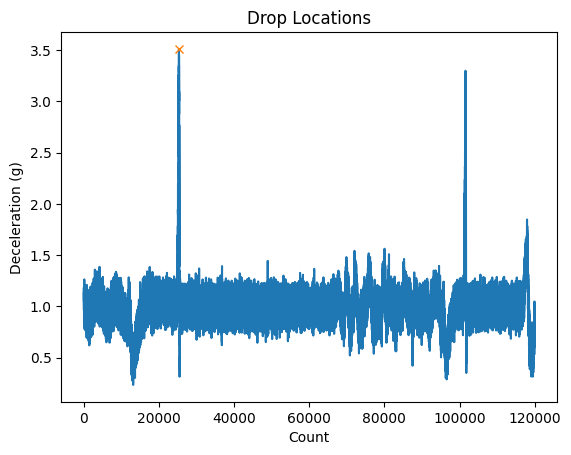

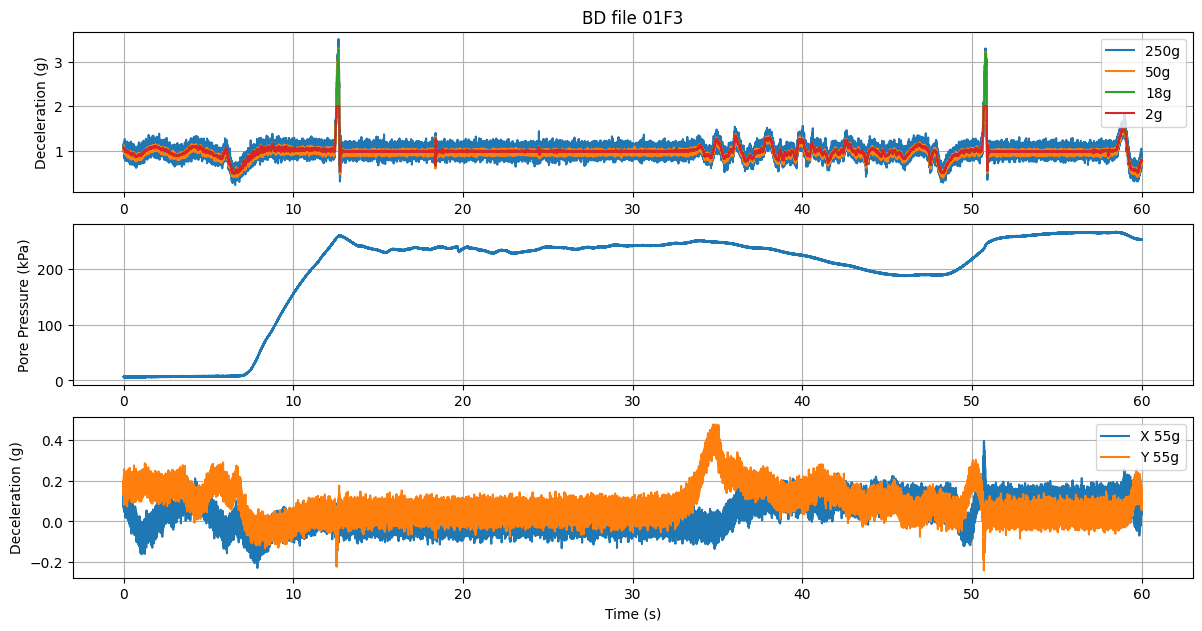

In [366]:
#Locate the drops
if drop_finding == "a":
    x = np.array(g250g)  # what accelerometer to get the peaks from - use 250 because it will never be maxed out
    max250 = max(g250g)

    peaks, _ = find_peaks(x, height = 2, distance=1000, prominence=3)  # finds the largest peaks more than 2g spaced at least 10000 counts apart

    peaksArray = np.array(peaks)  # prints a list of the count where the peaks occur
    
    #peaksArray = filter(filterpeak, peaksArray)

    #print(peaksArray)
    q = (peaksArray.shape) #gives number of peaks
    nDrops = int(q[0]) #number of drops in the file
    #print(nDrops)

if drop_finding == "m":
    manual_peak_pick()

peakplot()
overviewplot()
#print(peaksArray)

Define the analysis function

In [367]:
def analyze(drop_n, drop_ng, acc_n, acc_ng, acc_nName, acc_nNameg, qdyn_n_m, qdyn_n_p, output_table_n): # took out 
        
    global output_table

    drop_n = dfCal[dropstart:dropend]  # start and end points of the drop in m/s^2
    drop_ng = dfCalg[dropstart:dropend]  # start and end points of the drop in g
    drop_n = pd.DataFrame(drop_n)  # makes dataframe including all data within the start and end points of the drop
    drop_ng = pd.DataFrame(drop_ng)
    dg = drop_ng 
    d = drop_n
    accPick(dg, d)  # chooses what accelerometer to use
    acc_n = acc
    acc_ng = accg
    acc_nName = accName
    acc_nNameg = accNameg
    #findchangepts() #automatically identifies the moment of penetration
    peakpick() #interactive graph for user to choose start of penetration
    plt.close()
    endpick()
    plt.close()
    print("penstart: ", penstart)
    print("penend: ", penend)
    #finddropend(n-1) #automatically find the end of the drop
    offset = acc_ng[penstart] #sets the offset to be the acceleration at the moment of impact
    print("offset: ", offset)
    #print(drop)
    dg = dfCalg[penstart:penend] #chops the file to only include penetration 
    d = dfCal[penstart:penend]
    acc_ng = accg[penstart:penend]
    acc_ng = acc_ng-offset
    acc_n = acc[penstart:penend]
    offsetms = offset * 9.80665
    acc_n = acc_n-offsetms

    drop_n = d
    drop_ng = dg
    
    integration(d, acc_n) #double integration to solve for velocity and penetration depth
    drop_n = d
    areafind() #area calculations for bearing capacity calculations
    print("Acc_n: ",acc_n.shape)
    print("area: ", len(area_m))
    qdynfun(acc_n) #calculation of dynamic bearing capacity

    qsbcfun(acc_n) #calculation of quasi-static bearing capacities

    qsbc_table_m = bctable_m #qsbcfun(acc_n)[0]
    #print(qsbc_table_m)
    qsbc_table_p = bctable_p #qsbcfun(acc_n)[1]
    #print(bctable_m)
    qdyn_n_m = qdyn_m
    qdyn_n_p = qdyn_p
    integplot(drop_n,acc_nName)
    #qdynplot(drop1, qdyn1)
    print("Max penetration depth is: ", maxdep)
    print("Pre-truncation d1", drop_n)
    drop_n = pd.DataFrame(drop_n)
    drop_ng = pd.DataFrame(drop_ng)
    acc_n = pd.DataFrame(acc_n)
    qdyn_n_m = pd.DataFrame(qdyn_n_m)
    qdyn_n_p = pd.DataFrame(qdyn_n_p)
    #if droptype == "w":
        #bctable_m = pd.DataFrame(bctable_m)
        #bctable_p = pd.DataFrame(bctable_p)

    '''if truncate_at_cone == "y": #if terminating analysis at the cone-stem interface
        drop_n = drop_n.truncate(before=trunc_index) #this truncates each df such that only depths below cone height are considered
        drop_ng = drop_ng.truncate(before=trunc_index)
        acc_n = acc_n.truncate(before=trunc_index)
        acc_n = np.array(acc_n)
        acc_ng = acc_ng.truncate(before=trunc_index)
        acc_ng = np.array(acc_ng)
        drop_n = drop_n.truncate(before=trunc_index)
        qdyn_n_m = qdyn_n_m.truncate(before=trunc_index)
        qdyn_n_p = qdyn_n_p.truncate(before=trunc_index)

        if droptype == "w":
            qsbc_table_m = bctable_m.truncate(before=trunc_index)
            qsbc_table_p = bctable_p.truncate(before=trunc_index)'''


    firmnessfactor(acc_n, drop_n) #calculates the firmness factor
    
    if soiltype == "s":
        Dr = dr(acc_ng) #calculates relative density
        phi = duncan_correlation(Dr) #calculates friction angle
        su_m = 'NaN'
        su_p = 'NaN'
        max_su_m = 'NaN'
        max_su_p = 'NaN'

    elif soiltype == "u":
        if maxdep <= .2:
            Dr = dr(acc_ng)
            phi = duncan_correlation()
            su_m = 'NaN'
            su_p = 'NaN'
            max_su_m = 'NaN'
            max_su_p = 'NaN'
        else:
            Dr = 'NaN'
            phi = "NaN"
            su_m = qsbc_m/Nkt #need to add this still //*//
            su_p = qsbc_p/Nkt
            max_su_m = maxqsbc_default_m / Nkt
            max_su_p = maxqsbc_default_p / Nkt


    elif soiltype == "c":
        Dr = 'NaN'
        phi = "NaN"
        su_m = qsbc_m/Nkt #need to add this still //*//
        su_p = qsbc_p/Nkt
        max_su_m = maxqsbc_default_m / Nkt

        print(max_su_m)
        print(type(max_su_m))
        max_su_p = maxqsbc_default_p / Nkt

    pentime=(penend - penstart)/2 #ms #calculates the time of penetration

    #print(bctable_m) # = None
    #bctable_p = None

    dep_qsbc_comboplot(drop_ng,drop_n,acc_nNameg, qdyn_n_m, qsbc_m, qsbc_table_m)
    plt.show()
    ignore_drop()
    
    if n == 1:
        if keep_drop == "y":

            final_dep_qsbc_comboplot(drop_ng, drop_n, acc_nNameg, qdyn_n_m, qsbc_m, qsbc_table_m)
            plotName = fileNum+" "+str(n)+" - m"
            plt.savefig(plotPath / plotName) 

            final_dep_qsbc_comboplot(drop_ng, drop_n, acc_nNameg, qdyn_n_p, qsbc_p, qsbc_table_p)
            plotName = fileNum+" "+str(n)+" - p"
            plt.savefig(plotPath / plotName)
            print("pentime= ", pentime)

            if max_su_m == 'NaN':
                placeholder = 0 #do nothing
            else:
                
                # uncomment the below plot for a single value of strain rate factor K
                '''su_plot(drop_n, su_m)
                plotName = fileNum+" "+str(n)+" Undrained Strength -m"
                plt.savefig(plotPath / plotName)'''

                su_plot_with_range(drop_ng, drop_n, acc_nNameg, qsbc_m, qsbc_table_m)
                plotName = fileNum+" "+str(n)+" Undrained Strength - Range -m"
                plt.savefig(plotPath / plotName)

                '''su_plot(drop_n, su_p)
                plotName = fileNum+" "+str(n)+" Undrained Strength -p"
                plt.savefig(plotPath / plotName)'''

                su_plot_with_range(drop_ng, drop_n, acc_nNameg, qsbc_p, qsbc_table_p)
                plotName = fileNum+" "+str(n)+" Undrained Strength - Range -p"
                plt.savefig(plotPath / plotName)


            output_table_n = pd.DataFrame([BD, fileNum, n, soiltype, tiptype, droptype, maxdep*100, maxacc, maxvel, \
                maxbcdep*100, maxqdyn_m, maxqsbc_default_m, maxqdyn_p, maxqsbc_default_p, ff, pentime, Dr, phi, max_su_m, max_su_p]) \
                    #old version that give upper and lower bounds: pd.DataFrame([BD, fileNum, n, soiltype, tiptype, droptype, maxdep*100, maxacc, maxvel, maxbcdep*100, maxqdyn_m, maxHqsbc_m, maxLqsbc_m, maxAqsbc_m, maxqdyn_p, maxHqsbc_p, maxLqsbc_p, maxAqsbc_p, ff, pentime, Dr, phi])
            output_table_n = output_table_n.T
            output_table = output_table_n
            output_table.columns = ["BlueDrop", "BD File", "Drop No.", "Soil Type", "Tip Type", "Drop Type", \
                "Penetration Depth (cm)", "Maximum Deceleration (m/s^2)", "Impact Velocity (m/s)", "Depth of Max QSBC (cm)", \
                    "Max Qdyn (mantle) (kPa)", "Max QSBC (mantle) (kPa)", "Max Qdyn (projected) (kPa)", "Max QSBC (projected) (kPa)", \
                         "Firmness Factor (m-1)", "Penetration Time (ms)", "Relative Density (%)", "Friction Angle (deg.)", \
                            "Max Su (mantle) (kPa)", "Max Su (projected) (kPa)"]\
                            #old version that give upper and lower bounds:["BlueDrop", "BD File", "Drop No.", "Soil Type", "Tip Type", "Drop Type", "Penetration Depth (cm)", "Maximum Deceleration (m/s^2)", "Impact Velocity (m/s)", "Depth of Max QSBC (cm)", "Max Qdyn (mantle) (kPa)", "Max QSBC-Upper Bounds (mantle) (kPa)", "Max QSBC-Lower Bounds (mantle) (kPa)", "Max QSBC-Average (kPa) (mantle)", "Max Qdyn (projected) (kPa)", "Max QSBC-Upper Bounds (projected) (kPa)", "Max QSBC-Lower Bounds (projected) (kPa)", "Max QSBC-Average (kPa) (projected)", "Firmness Factor (m-1)", "Penetration Time (ms)", "Relative Density (%)", "Friction Angle (deg.)"]  # Creates an empty Dataframe in pandas from the output data
        else:
            dep_qsbc_comboplot(drop_ng,drop_n,acc_nNameg, qdyn_n_m, qsbc_m, qsbc_table_m)
            plotName = fileNum+" "+str(n)+" BC - REJECTED"
            plt.savefig(plotPath / plotName)
            output_table1 = pd.DataFrame([BD, fileNum, n, soiltype, tiptype, droptype,'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN'])
            output_table1 = output_table1.T
            output_table = output_table1
            output_table.columns = ["BlueDrop", "BD File", "Drop No.", "Soil Type", "Tip Type", "Drop Type", \
                "Penetration Depth (cm)", "Maximum Deceleration (m/s^2)", "Impact Velocity (m/s)", "Depth of Max QSBC (cm)", \
                    "Max Qdyn (mantle) (kPa)", "Max QSBC (mantle) (kPa)", "Max Qdyn (projected) (kPa)", "Max QSBC (projected) (kPa)", \
                         "Firmness Factor (m-1)", "Penetration Time (ms)", "Relative Density (%)", "Friction Angle (deg.)", \
                            "Max Su (mantle) (kPa)", "Max Su (projected) (kPa)"]\
                            #old version that give upper and lower bounds:["BlueDrop", "BD File", "Drop No.", "Soil Type", "Tip Type", "Drop Type", "Penetration Depth (cm)", "Maximum Deceleration (m/s^2)", "Impact Velocity (m/s)", "Depth of Max QSBC (cm)", "Max Qdyn (mantle) (kPa)", "Max QSBC-Upper Bounds (mantle) (kPa)", "Max QSBC-Lower Bounds (mantle) (kPa)", "Max QSBC-Average (kPa) (mantle)", "Max Qdyn (projected) (kPa)", "Max QSBC-Upper Bounds (projected) (kPa)", "Max QSBC-Lower Bounds (projected) (kPa)", "Max QSBC-Average (kPa) (projected)", "Firmness Factor (m-1)", "Penetration Time (ms)", "Relative Density (%)", "Friction Angle (deg.)"]  # Creates an empty Dataframe in pandas from the output data
    else:
        if keep_drop == "y":
            final_dep_qsbc_comboplot(drop_ng, drop_n, acc_nNameg, qdyn_n_m, qsbc_m, qsbc_table_m)
            plotName = fileNum+" "+str(n)+" Bearing Capacity - m"
            plt.savefig(plotPath / plotName) 
            final_dep_qsbc_comboplot(drop_ng, drop_n, acc_nNameg, qdyn_n_p, qsbc_p, qsbc_table_p)
            plotName = fileNum+" "+str(n)+" Bearing Capacity - p"
            plt.savefig(plotPath / plotName) 
            print("pentime= ", pentime)

            if max_su_m == 'NaN':
                placeholder = 0
            else:

                # uncomment the below plot for a single value of strain rate factor K
                '''su_plot(drop_n, su_m)
                plotName = fileNum+" "+str(n)+" Undrained Strength -m"
                plt.savefig(plotPath / plotName)'''

                su_plot_with_range(drop_ng, drop_n, acc_nNameg, qsbc_m, qsbc_table_m)
                plotName = fileNum+" "+str(n)+" Undrained Strength - Range -m"
                plt.savefig(plotPath / plotName)

                '''su_plot(drop_n, su_p)
                plotName = fileNum+" "+str(n)+" Undrained Strength -p"
                plt.savefig(plotPath / plotName)'''

                su_plot_with_range(drop_ng, drop_n, acc_nNameg, qsbc_p, qsbc_table_p)
                plotName = fileNum+" "+str(n)+" Undrained Strength - Range -p"
                plt.savefig(plotPath / plotName)

            output_table_n = pd.DataFrame([BD, fileNum, n, soiltype, tiptype, droptype, maxdep*100, maxacc, maxvel, \
                maxbcdep*100, maxqdyn_m, maxqsbc_default_m, maxqdyn_p, maxqsbc_default_p, ff, pentime, Dr, phi, max_su_m, max_su_p]) 
            output_table_n = output_table_n.T
            output_table_n.columns = ["BlueDrop", "BD File", "Drop No.", "Soil Type", "Tip Type", "Drop Type", \
                "Penetration Depth (cm)", "Maximum Deceleration (m/s^2)", "Impact Velocity (m/s)", "Depth of Max QSBC (cm)", \
                    "Max Qdyn (mantle) (kPa)", "Max QSBC (mantle) (kPa)", "Max Qdyn (projected) (kPa)", "Max QSBC (projected) (kPa)", \
                         "Firmness Factor (m-1)", "Penetration Time (ms)", "Relative Density (%)", "Friction Angle (deg.)", \
                            "Max Su (mantle) (kPa)", "Max Su (projected) (kPa)"]\
                            #old version that give upper and lower bounds:["BlueDrop", "BD File", "Drop No.", "Soil Type", "Tip Type", "Drop Type", "Penetration Depth (cm)", "Maximum Deceleration (m/s^2)", "Impact Velocity (m/s)", "Depth of Max QSBC (cm)", "Max Qdyn (mantle) (kPa)", "Max QSBC-Upper Bounds (mantle) (kPa)", "Max QSBC-Lower Bounds (mantle) (kPa)", "Max QSBC-Average (kPa) (mantle)", "Max Qdyn (projected) (kPa)", "Max QSBC-Upper Bounds (projected) (kPa)", "Max QSBC-Lower Bounds (projected) (kPa)", "Max QSBC-Average (kPa) (projected)", "Firmness Factor (m-1)", "Penetration Time (ms)", "Relative Density (%)", "Friction Angle (deg.)"]  # Creates an empty Dataframe in pandas from the output data
        else:
            dep_qsbc_comboplot(drop_ng,drop_n,acc_nNameg, qdyn_n_m, qsbc_m, bctable_m)
            plotName = fileNum+" "+str(n)+" BC - REJECTED"
            plt.savefig(plotPath / plotName)
            output_table_n = pd.DataFrame([BD, fileNum, n, soiltype, tiptype, droptype,'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN'])
            output_table_n = output_table_n.T
            output_table_n.columns = ["BlueDrop", "BD File", "Drop No.", "Soil Type", "Tip Type", "Drop Type", \
                "Penetration Depth (cm)", "Maximum Deceleration (m/s^2)", "Impact Velocity (m/s)", "Depth of Max QSBC (cm)", \
                    "Max Qdyn (mantle) (kPa)", "Max QSBC (mantle) (kPa)", "Max Qdyn (projected) (kPa)", "Max QSBC (projected) (kPa)", \
                         "Firmness Factor (m-1)", "Penetration Time (ms)", "Relative Density (%)", "Friction Angle (deg.)", \
                            "Max Su (mantle) (kPa)", "Max Su (projected) (kPa)"]\
                            #old version that give upper and lower bounds:["BlueDrop", "BD File", "Drop No.", "Soil Type", "Tip Type", "Drop Type", "Penetration Depth (cm)", "Maximum Deceleration (m/s^2)", "Impact Velocity (m/s)", "Depth of Max QSBC (cm)", "Max Qdyn (mantle) (kPa)", "Max QSBC-Upper Bounds (mantle) (kPa)", "Max QSBC-Lower Bounds (mantle) (kPa)", "Max QSBC-Average (kPa) (mantle)", "Max Qdyn (projected) (kPa)", "Max QSBC-Upper Bounds (projected) (kPa)", "Max QSBC-Lower Bounds (projected) (kPa)", "Max QSBC-Average (kPa) (projected)", "Firmness Factor (m-1)", "Penetration Time (ms)", "Relative Density (%)", "Friction Angle (deg.)"]  # Creates an empty Dataframe in pandas from the output data

        output_table = pd.concat([output_table, output_table_n])


In [368]:
#print(bctable_m.columns[:])

Run Preliminary Analysis

peak index: 25311
start of penetration:  24888
penstart:  24888
penend:  25436
offset:  1.0543592120623222
Acc_n:  (548,)
area:  548
       Mantle Qdyn  Projected Qdyn     Depth
24888     0.000000        0.000000  0.000000
24889    -0.031337       -0.033740  0.001677
24890    -0.042234       -0.048710  0.003354
24891     0.092509        0.113786  0.005031
24892     0.062448        0.081597  0.006708
...            ...             ...       ...
25431     0.409227        2.012464  0.347499
25432     0.349813        1.720282  0.347499
25433     0.304657        1.498217  0.347499
25434     0.244549        1.202623  0.347499
25435     0.170404        0.837997  0.347499

[548 rows x 3 columns]
3cm index 24906
0th index 24888
<class 'int'>
       Mantle Qdyn  Projected Qdyn     Depth
24906     0.303091        0.720255  0.030108
24907     0.301474        0.739336  0.031771
24908     0.311619        0.787890  0.033433
24909     0.321806        0.838074  0.035094
24910     0.318577        0.8538

C:\Users\elise\AppData\Local\Temp\ipykernel_2356\377958712.py:172: RuntimeWarning: divide by zero encountered in log10
  srcv = np.log10(vel/0.02) #Velocity portion of the strain rate correction.
C:\Users\elise\AppData\Local\Temp\ipykernel_2356\377958712.py:172: RuntimeWarning: invalid value encountered in log10
  srcv = np.log10(vel/0.02) #Velocity portion of the strain rate correction.


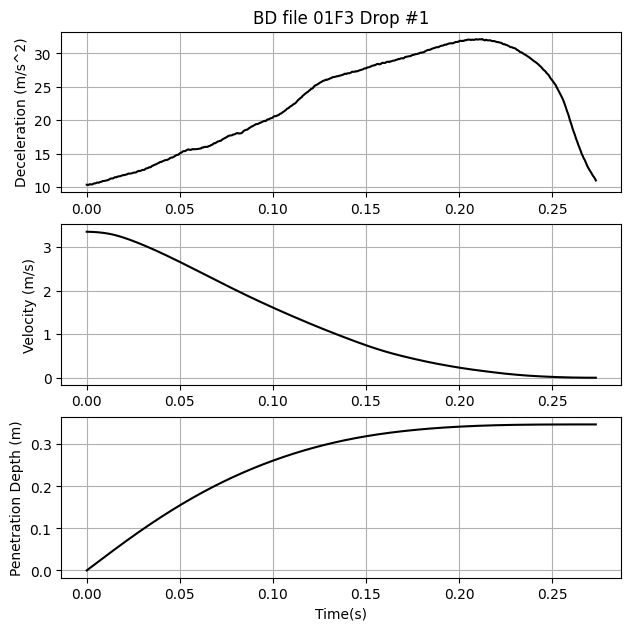

Max penetration depth is:  0.3475
Pre-truncation d1          Count  Time (s)  2g (m/s^2)  18g (m/s^2)  50g (m/s^2)  200g (m/s^2)  \
24888  24888.0   12.4445   10.311738    10.339732    10.231447     15.655255   
24889  24889.0   12.4450   10.296372    10.313646    10.341915     15.715777   
24890  24890.0   12.4455   10.332639    10.302072    10.337909     15.721072   
24891  24891.0   12.4460   10.386074    10.427705    10.329281     15.747802   
24892  24892.0   12.4465   10.434909    10.402818    10.215424     15.797733   
...        ...       ...         ...          ...          ...           ...   
25431  25431.0   12.7160   11.850961    11.895668    11.377105     17.388687   
25432  25432.0   12.7165   11.616768    11.669768    10.913819     17.103985   
25433  25433.0   12.7170   11.453489    11.498078    10.953415     16.872491   
25434  25434.0   12.7175   11.226517    11.269539    11.223652     16.606953   
25435  25435.0   12.7180   10.986850    10.987629    11.317326     1

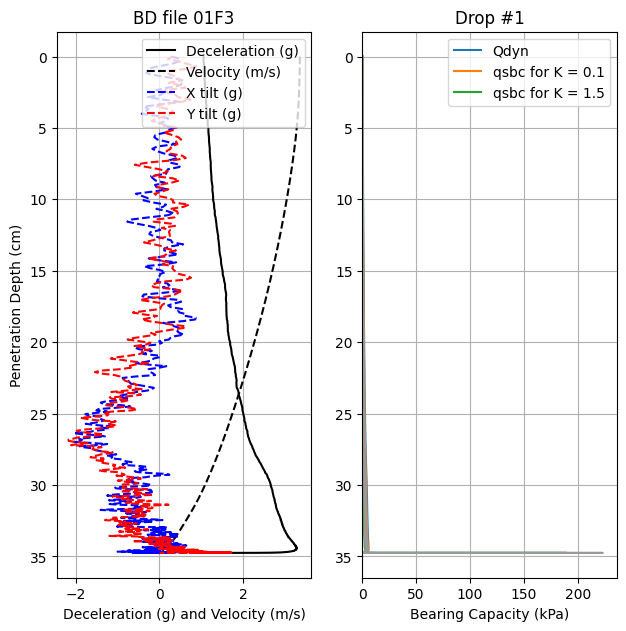

Keep Drop? (y/n)
pentime=  274.0
  BlueDrop BD File Drop No. Soil Type Tip Type Drop Type  \
0        3    01F3        1         c        b         w   

  Penetration Depth (cm) Maximum Deceleration (m/s^2) Impact Velocity (m/s)  \
0                  34.75                    21.828743                   3.4   

  Depth of Max QSBC (cm) Max Qdyn (mantle) (kPa) Max QSBC (mantle) (kPa)  \
0                  34.46                     5.7                5.270454   

  Max Qdyn (projected) (kPa) Max QSBC (projected) (kPa) Firmness Factor (m-1)  \
0                       28.2                  25.918585                   2.4   

  Penetration Time (ms) Relative Density (%) Friction Angle (deg.)  \
0                 274.0                  NaN                   NaN   

  Max Su (mantle) (kPa) Max Su (projected) (kPa)  
0              0.527045                 2.591858  
Run Complete


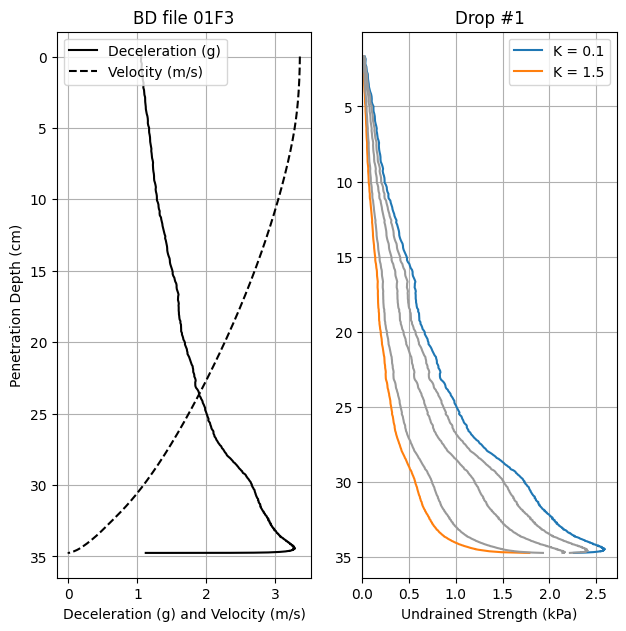

In [369]:
a = 0 #index variable for drop analysis
n = 1 #index variable for drop analysis

while n <= nDrops :
    peak = int(peaksArray[a])  # count at the ath drop
    print("peak index:" , peak)
    dropstartend(peak) #zooms in the drop file to only consider 500 counts before and 1500 counts after the peak deceleration
    #print(dropstart, dropend)

    if n == 1 :
        drop1 = None
        drop1g = None
        acc1 = None
        acc1g = None
        acc1Name = None
        acc1Nameg = None
        qdyn1_m = None
        qdyn1_p = None
        output_table1 = None
        analyze(drop1, drop1g, acc1, acc1g, acc1Name, acc1Nameg, qdyn1_m, qdyn1_p, output_table1)

    if n == 2 :
        drop2 = None
        drop2g = None
        acc2 = None
        acc2g = None
        acc2Name = None
        acc2Nameg = None
        qdyn2_m = None
        qdyn2_p = None
        output_table2 = None
        analyze(drop2, drop2g, acc2, acc2g, acc2Name, acc2Nameg, qdyn2_m, qdyn2_p, output_table2)

    if n == 3 :
        drop3 = None
        drop3g = None
        acc3 = None
        acc3g = None
        acc3Name = None
        acc3Nameg = None
        qdyn3_m = None
        qdyn3_p = None
        output_table3 = None
        analyze(drop3, drop3g, acc3, acc3g, acc3Name, acc3Nameg, qdyn3_m, qdyn3_p, output_table3)

    if n == 4 :
        drop4 = None
        drop4g = None
        acc4 = None
        acc4g = None
        acc4Name = None
        acc4Nameg = None
        qdyn4_m = None
        qdyn4_p = None
        output_table4 = None
        analyze(drop4, drop4g, acc4, acc4g, acc4Name, acc4Nameg, qdyn4_m, qdyn4_p, output_table4)

    if n == 5 :
        drop5 = None
        drop5g = None
        acc5 = None
        acc5g = None
        acc5Name = None
        acc5Nameg = None
        qdyn5_m = None
        qdyn5_p = None
        output_table5 = None
        analyze(drop5, drop5g, acc5, acc5g, acc5Name, acc5Nameg, qdyn5_m, qdyn5_p, output_table5)

    if n == 6 :
        drop6 = None
        drop6g = None
        acc6 = None
        acc6g = None
        acc6Name = None
        acc6Nameg = None
        qdyn6_m = None
        qdyn6_p = None
        output_table6 = None
        analyze(drop6, drop6g, acc6, acc6g, acc6Name, acc6Nameg, qdyn6_m, qdyn6_p, output_table6)

    if n == 7 :
        drop7 = None
        drop7g = None
        acc7 = None
        acc7g = None
        acc7Name = None
        acc7Nameg = None
        qdyn7_m = None
        qdyn7_p = None
        output_table7 = None
        analyze(drop7, drop7g, acc7, acc7g, acc7Name, acc7Nameg, qdyn7_m, qdyn7_p, output_table7)

    if n == 8 :
        drop8 = None
        drop8g = None
        acc8 = None
        acc8g = None
        acc8Name = None
        acc8Nameg = None
        qdyn8_m = None
        qdyn8_p = None
        output_table8 = None
        analyze(drop8, drop8g, acc8, acc8g, acc8Name, acc8Nameg, qdyn8_m, qdyn8_p, output_table8)

    if n == 9 :
        drop9 = None
        drop9g = None
        acc9 = None
        acc9g = None
        acc9Name = None
        acc9Nameg = None
        qdyn9_m = None
        qdyn9_p = None
        output_table9 = None
        analyze(drop9, drop9g, acc9, acc9g, acc9Name, acc9Nameg, qdyn9_m, qdyn9_p, output_table9)

    if n == 10 :
        drop10 = None
        drop10g = None
        acc10 = None
        acc10g = None
        acc10Name = None
        acc10Nameg = None
        qdyn10_m = None
        qdyn10_p = None
        output_table10 = None
        analyze(drop10, drop10g, acc10, acc10g, acc10Name, acc10Nameg, qdyn10_m, qdyn10_p, output_table10)

    n = n + 1
    a = a + 1
    
print(output_table)

exporttoexcel()

print("Run Complete")


In [370]:
'''
HISTORICAL CALIBRATION FACTORS

blueDrop #1 calibration factors:
- for data collected from July 2020 onward, use the following calibration factors:
            g2g=(df['g2g']-42590.9)/1626361.1; %accelerometers are in g
            g18g=(df['g18g']-44492.9)/161125.5;
            g50g=(df['g50g']-171656.1)/64020.3;
            ppm=(df['ppm']+31776.1)/20679.7;  % this is psi
            g200g=(df['g200g']-723404.8)/32209.7);
            gX55g=(df['gX55g']-54881.1)/64858.6);
            gY55g=(df['gY55g']-28735.5)/63839.9;
            g250g=(df['g250g']+13299.7)/13697.1;
            ppm=ppm*6.89475729; % convert into kPa

blueDrop #2 calibration factors:

- for data collected between July 2019 and September 2021, use the following calibration factors:
   g2g=((double(F(:,3)))+31683)/1624691; %accelerometers are in g
            g18g=((double(F(:,4)))-27002.4)/159942.4;
            g50g=((double(F(:,5)))+91943.2)/63865;
            ppm=((double(F(:,6)))+37971.1)/12982;  % this is psi
            g200g=((double(F(:,7)))-17936.6)/26226.6;
            gX55g=((double(F(:,8)))+89249)/66161.6;
            gY55g=((double(F(:,9)))+11088.8)/64773.6;
            g250g=((double(F(:,10)))+18888.6)/13518.9;
            ppm=ppm*6.89475729; % convert into kPa

- for data collected following September 2021, use the following calibration factors:
   g2g=((double(F(:,3)))+37242.2)/1639250.2; %accelerometers are in g
            g18g=((double(F(:,4)))-26867.0)/160460.5;
            g50g=((double(F(:,5)))-213923.3)/64080.7;
            ppm=((double(F(:,6)))+55518.9)/18981.7;  % this is psi
            g200g=((double(F(:,7)))-171448.6)/30334.2;
            gX55g=((double(F(:,8)))-54242.6)/64767.7;
            gY55g=((double(F(:,9)))-40574.2)/66343.1;
            g250g=((double(F(:,10)))-40614.9)/13654.6;

blueDrop #3 calibration factors:

- for data collected before July 2019, use the following calibration factors:
   g2g=((double(F(:,3)))-38285.6)/1615800.9; %accelerometers are in g
   g18g=((double(F(:,4)))+13738)/163516.8;
     g50g=((double(F(:,5)))-238520.6)/63666.0;
   ppm=((double(F(:,6)))-139040.1)/20705.0;  % this is psi
   g200g=((double(F(:,7)))+12142.6)/27751.9;
   gX55g=((double(F(:,8)))-90237.0)/65351.5;
   gY55g=((double(F(:,9)))-57464.2)/65545.5;
   g250g=((double(F(:,10)))-40420.3)/13636.9;

- for data collected after July 2019, use the following calibration factors:
   g2g=((double(F(:,3)))-38285.6)/1615800.9; %accelerometers are in g
            g18g=((double(F(:,4)))+13738)/163516.8;
            g50g=((double(F(:,5)))-238520.6)/63666;
            ppm=((double(F(:,6)))-139040.1)/20705;  % this is psi
            g200g=(((double(F(:,7)))+12142.6)/27751.9);
            gX55g=((double(F(:,8)))-90237)/65351.5;
            gY55g=((double(F(:,9)))-57464.2)/65545.5;
            g250g=((double(F(:,10)))-40420.3)/13636.9;
            g2g(end) = []; g2g = [1;g2g];
            g200g(end) = []; g200g = [1;g200g];
            g18g(end) = []; g18g = [1;g18g];
            g200g(end) = []; g200g = [1;g200g];
            ppm=ppm*6.89475729; % convert into kPa'''

"\nHISTORICAL CALIBRATION FACTORS\n\nblueDrop #1 calibration factors:\n- for data collected from July 2020 onward, use the following calibration factors:\n            g2g=(df['g2g']-42590.9)/1626361.1; %accelerometers are in g\n            g18g=(df['g18g']-44492.9)/161125.5;\n            g50g=(df['g50g']-171656.1)/64020.3;\n            ppm=(df['ppm']+31776.1)/20679.7;  % this is psi\n            g200g=(df['g200g']-723404.8)/32209.7);\n            gX55g=(df['gX55g']-54881.1)/64858.6);\n            gY55g=(df['gY55g']-28735.5)/63839.9;\n            g250g=(df['g250g']+13299.7)/13697.1;\n            ppm=ppm*6.89475729; % convert into kPa\n\nblueDrop #2 calibration factors:\n\n- for data collected between July 2019 and September 2021, use the following calibration factors:\n   g2g=((double(F(:,3)))+31683)/1624691; %accelerometers are in g\n            g18g=((double(F(:,4)))-27002.4)/159942.4;\n            g50g=((double(F(:,5)))+91943.2)/63865;\n            ppm=((double(F(:,6)))+37971.1)/1298